# Outlier Detection - Smart Meter London

## Objective of this notebook

- Show different unsupervised Deep Learning methods for unsupervised anomaly detection in time series
    1. Auto Encoder
    2. Variational Auto Encoder
    
### References

- Haowen Xu, Wenxiao Chen, Nengwen Zhao, Zeyan Li, Jiahao Bu, Zhihan Li, Ying Liu, Youjian Zhao, Dan Pei, Yang Feng, Jie Chen, Zhaogang Wang, Honglin Qiao: **Unsupervised Anomaly Detection via Variational Auto-Encoder for Seasonal KPIs in Web Applications.** CoRR abs/1802.03903 (2018) [[Link](https://arxiv.org/abs/1802.03903)]

In [1]:
# ignore warnings in this demo notebook
import warnings; warnings.simplefilter('ignore')

# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

# enables the %%R magic
%load_ext rpy2.ipython

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Deep Learning
import tensorflow as tf
import keras
from keras.callbacks import History, TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Custom functions
from python_code.data_preparation import create_tensors
from python_code.data_preparation import load_series

rcParams['figure.figsize'] = 15, 6

Using TensorFlow backend.


# LSTM Auto Encoder for Outlier Detection

In step 1 we fit a LSTM Autoencoder and use the reconstruction error as an outlier score. 

## What is an Auto Encoder?

An auto encoder is an artificial neural network that is used for learning (unsupervised) of efficient codings. The goal is to induce a representation for a data sample to approximate the identity function:

$$
ID: X \rightarrow X
$$

With auto encoders you are trying to reconstruct a given input $X$, instead of predicting a target value $Y$ given $X$ with a LSTM prediction network. Therefore, auto encoders are unsupervised methods. 

![title](./imgs/autoencoder.png)

[Image Source](http://philipperemy.github.io/anomaly-detection/)

Auto encoders has always two parts:

1. encoder
2. decoder

In the **encoding** part, the network tries to find a *good* low dimensional representation of the data. The **decoding** part tries to reconstruct the data from the low dimensional representation. For [tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) data, auto endoers can be seen as a non-linear alternative to PCA.

## Auto Encoder for Anomaly Detection

Applying auto encoders is straight foreward:

1. Train the auto encoder on a training set $X_{train}$ and validate the performance on a validation data set $X_{valid}$
2. Outlier detection:
    
    a. Use a dynamic threshold on the reconstruction error (e.g. plus-minus 3 times the standard deviation of the running mean) for marking outlier samples
    b. Apply a MC approach ([Uncertainty in Deep Learning](http://mlg.eng.cam.ac.uk/yarin/blog_2248.html)) the confidence band estimation
    
In the following example we will apply method a. for outlier detection. As we do not have outlier labels, we are not able to evaluate the performance of this approach for this dataset.

## Auto Encoder: Architecture

We will apply a simple auto encoder model on single smart meter data. We feed the AE with daily data and use following network architecture. The encoder can be used, as noted above, as a low dimensional representation of the time series data. 

In [2]:
encoder_input = keras.Input((24, 1))
encoder = keras.layers.LSTM(units = 128, \
                            batch_input_shape = (1, None, 24), \
                            return_sequences=True, \
                            stateful=False, \
                            kernel_initializer='glorot_uniform')(encoder_input)
encoder = keras.layers.LSTM(units = 32, \
                            batch_input_shape = (1, None, 24), \
                            return_sequences=True, \
                            stateful=False, \
                            return_state = True, \
                            kernel_initializer='glorot_uniform')(encoder)

decoder = keras.layers.LSTM(units = 32, \
                            return_sequences=True, \
                            stateful=False, \
                            return_state = False, \
                            kernel_initializer='glorot_uniform')(encoder)
decoder = keras.layers.LSTM(units = 128, \
                            return_sequences=False, \
                            stateful=False, \
                            return_state = False, \
                            kernel_initializer='glorot_uniform')(decoder)
decoder_output = keras.layers.Dense(units = 24, activation = "tanh")(decoder)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [3]:
ae_model = keras.Model(encoder_input, decoder_output)
ae_model.compile(loss="mse", optimizer=keras.optimizers.Adam())

Instructions for updating:
keep_dims is deprecated, use keepdims instead


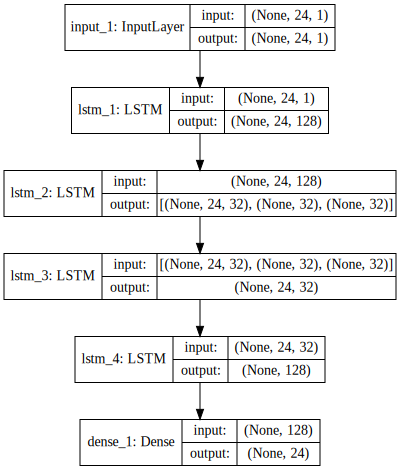

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ae_model, show_shapes=True).create(prog='dot', format='svg'))

## Data Preparation

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. In this example, we just have a look at one series, namely the series with id **MAC000002**. We have:

- Number of series: 1
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)

In [5]:
#data_path = '../prepared_data/london_smart_meter/'
data_path = "https://raw.githubusercontent.com/anofox/m3_konferenz/master/prepared_data/london_smart_meter/"
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df = df[['energy']]
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

Similar as for LSTM time series prediction, we use daily data. We will use 90 days for training (10% for validation) and 30 days for predicting outliers.

In [6]:
from datetime import datetime
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')

In [7]:
df_train = df[df.index <= date_train]
df_test = df[df.index > date_train]

### Normalization
LSTMs need a 3 dimensional input arrays ([samples, n_in, n_features]) and normalized features. So, let us first normalize energy consumption attribute into range (0, 1). 

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])
df_train.describe()

,energy
count,2160.000000
mean,0.090101
std,0.118516
min,0.000000
25%,0.005903
50%,0.052302
75%,0.140024
max,1.000000


###  Tensors

Now, we can calculate the training tensors.

In [9]:
train_X, train_y = create_tensors(df_train, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
add_y = train_y[88,:].reshape([1, train_X.shape[1], train_X.shape[2]])
train_X = np.append(train_X, add_y, axis = 0)
train_y = train_X
train_y = train_y.reshape([train_y.shape[0], train_y.shape[1]])

### Train LSTM Auto Encoder

In [10]:
history = History()
nan_terminator = TerminateOnNaN()
early_stopping = EarlyStopping(patience=10, 
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=50, 
                              verbose=1, 
                              mode='auto', 
                              epsilon=0.0001, 
                              cooldown=0, 
                              min_lr=1e-8)

ae_model.fit(x=train_X, 
             y=train_y, 
             epochs=250, 
             verbose=1, 
             batch_size = 128,
             validation_split=.1,
             shuffle=True,
             callbacks=[history, nan_terminator, reduce_lr])

Train on 81 samples, validate on 9 samples
Epoch 1/250
81/81 [==============================] - 2s 20ms/step - loss: 0.0207 - val_loss: 0.0345
Epoch 2/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.0332
Epoch 3/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0190 - val_loss: 0.0315
Epoch 4/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0292
Epoch 5/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0263
Epoch 6/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0143 - val_loss: 0.0225
Epoch 7/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0183
Epoch 8/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0152
Epoch 9/250
81/81 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 0.0139
Epoch 10/250
81/81 [==============================] - 0s 2ms/step

Epoch 83/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0088
Epoch 84/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0086
Epoch 85/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0085
Epoch 86/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0084
Epoch 87/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0083
Epoch 88/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0083
Epoch 89/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0083
Epoch 90/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0083
Epoch 91/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 92/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0079


Epoch 165/250
81/81 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 166/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 167/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 168/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 169/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 170/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 171/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 172/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 173/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 174/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0025 - val_los

81/81 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 247/250
81/81 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 248/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 249/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 250/250
81/81 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0053


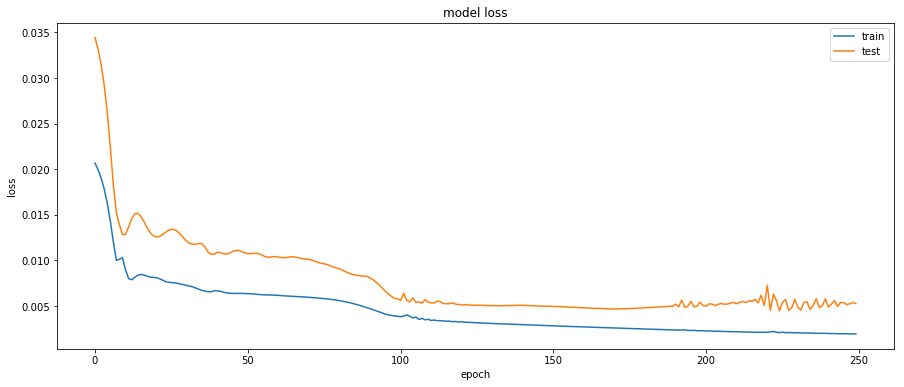

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Outlier Detection on Test Data

In [12]:
test_X, test_y = create_tensors(df_test, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
add_y = test_y[29,:].reshape([1, test_X.shape[1], test_X.shape[2]])
test_X = np.append(test_X, add_y, axis = 0)

Now, perform prediction and rescale reconstructed values.

In [13]:
prediction = ae_model.predict(test_X)
X_reconst = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
df_test['energy'] =  scaler.inverse_transform(df_test[['energy']])

In [14]:
df_test['reconstruction'] = X_reconst

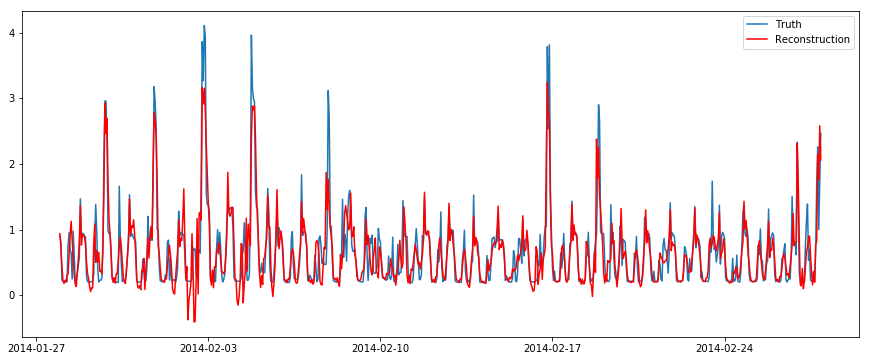

In [15]:
plt.plot(df_test['energy'])
plt.plot(df_test['reconstruction'], color='red')
plt.legend(['Truth', 'Reconstruction'], loc='upper right')
plt.show()

In the next step the point-wise absolute error is calculated and a 24 value long rolling mean and standard deviation is calculated. Then e.g. mean plus 2 time the standard deviation can be used as a threshold for marking outlier regions.

In [16]:
df_test['mse'] = np.abs(df_test['energy'] - df_test['reconstruction'])
df_test['mse'] = df_test['mse'] / df_test['mse'].max()
df_test['rolling_mean'] = df_test['mse'].rolling(24).mean()
df_test['rolling_std'] = df_test['mse'].rolling(24).std()
df_test['rolling_mean'].fillna(0, inplace=True)
df_test['rolling_std'].fillna(0, inplace=True)

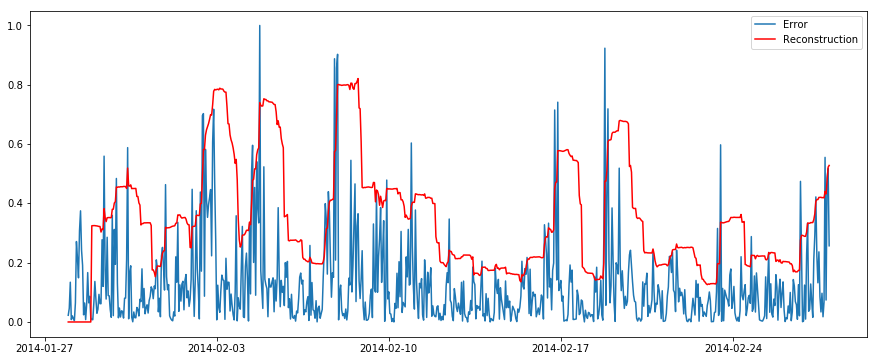

In [17]:
plt.plot(df_test['mse'])
plt.plot(df_test['rolling_mean'] + 2 * df_test['rolling_std'], color='red')
plt.legend(['Error', 'Reconstruction'], loc='upper right')

A detailed evaluation of this algorithm is not possible, as we do not know the truth label of this dataset (or are not able to dick into it deeper for finding good explanations for this outliers).

# Donut for Outlier Detection

Let us try another method. It uses a Variational Auto Encoder for detecting outliers in seasonal time series. It is developed by a Data Science team at Alibaba and is used web based KPIs (see reference on top of the page).

We use for this example the public available Python package from the authors [github](https://github.com/korepwx/donut) repository.

A nice introduction on VAEs can be found on [towardsdatascience](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf).

Data preparation is different from the above one. The Donut API needs as input four arrays:
- timestamp,
- value, 
- labels, and 
- missing.

As we do not have any outlier labels and no missing values, we set both arrays to 0. 

Note: Method *complete_timestamp* from Donut can be used to fill missing gaps and for generating the missing array. 

We will use the same train / test split as above.

In [22]:
df_train = df[df.index <= date_train]
df_test = df[df.index > date_train]

train_timestamp, test_timestamp = df_train.index, df_test.index
train_values, test_values = df_train['energy'], df_test['energy']
train_labels, test_labels = np.zeros_like(train_values, dtype=np.int32), np.zeros_like(test_values, dtype=np.int32)
train_labels, test_labels = np.zeros_like(train_values, dtype=np.int32), np.zeros_like(test_values, dtype=np.int32)
train_missing, test_missing = np.zeros_like(train_values, dtype=np.int32), np.zeros_like(test_values, dtype=np.int32)

Finally, we have to standardize our data.

In [23]:
from donut import complete_timestamp, standardize_kpi
train_values, mean, std = standardize_kpi(
    train_values, excludes=np.logical_or(train_labels, train_missing))
test_values, _, _ = standardize_kpi(test_values, mean=mean, std=std)

The example Donut model is used for our example data.

In [34]:
import tensorflow as tf
from donut import Donut
from tensorflow import keras as K
from tfsnippet.modules import Sequential

tf.reset_default_graph()
with tf.variable_scope('model') as model_vs:
    model = Donut(
        h_for_p_x=Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001),
                           activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001),
                           activation=tf.nn.relu),
        ]),
        h_for_q_z=Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001),
                           activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001),
                           activation=tf.nn.relu),
        ]),
        x_dims=336, 
        z_dims=5,
    )

Train the model and perform predictions on the test set.

In [35]:
from donut import DonutTrainer, DonutPredictor

trainer = DonutTrainer(model=model, model_vs=model_vs)
predictor = DonutPredictor(model)

with tf.Session().as_default():
    trainer.fit(train_values, train_labels, train_missing, mean, std)
    test_score = predictor.get_score(values=test_values, missing=test_missing)

Trainable Parameters (123382 in total)
------------------------------------------------------
donut/p_x_given_z/mean/dense/bias    (336,)      336
donut/p_x_given_z/mean/dense/kernel  (100, 336)  33600
donut/p_x_given_z/std/dense/bias     (336,)      336
donut/p_x_given_z/std/dense/kernel   (100, 336)  33600
donut/q_z_given_x/mean/dense/bias    (5,)        5
donut/q_z_given_x/mean/dense/kernel  (100, 5)    500
donut/q_z_given_x/std/dense/bias     (5,)        5
donut/q_z_given_x/std/dense/kernel   (100, 5)    500
sequential/_0/dense/bias             (100,)      100
sequential/_0/dense/kernel           (5, 100)    500
sequential/_1/dense/bias             (100,)      100
sequential/_1/dense/kernel           (100, 100)  10000
sequential_1/_0/dense/bias           (100,)      100
sequential_1/_0/dense/kernel         (336, 100)  33600
sequential_1/_1/dense/bias           (100,)      100
sequential_1/_1/dense/kernel         (100, 100)  10000

[Epoch 10/256] Learning rate decreased to 0.00075
[

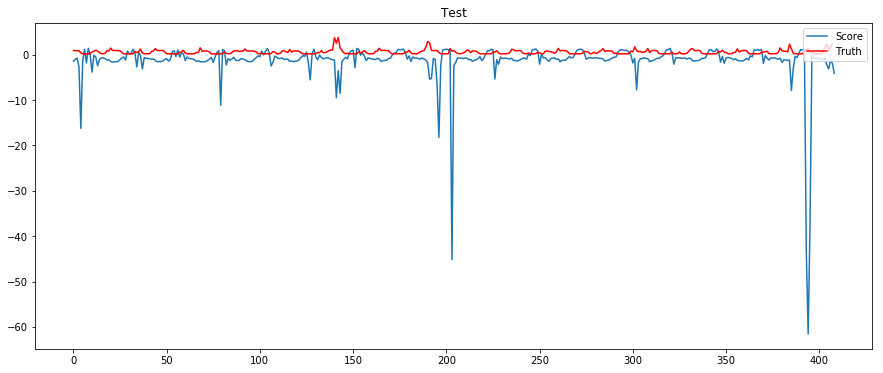

In [37]:
plt.plot(test_score)
plt.plot(df_test['energy'].values[336:], color='red')
plt.legend(['Score', 'Truth'], loc='upper right')
plt.title("Test")
plt.show()

# Outline

There are much more methods for detecting outliers in time series, e.g.

1. Talagala et al. ([1]) apply their method on multiple correlated time series (sensor data on pipelines) and use time series features and dimension reduction on each window with finally applying extreme value theory for detecting outliers.

2. The Uber machine learning team uses a large portfolio from different cities for training their model. This model is then used for forecasting a single series and for anomaly detection they calculte confidence bands.

### More References

[1] Talagala, P. D., Hyndman, R. J., Smith-Miles, K., Kandanaarachchi, S., & Muñoz, M. A. (2018). Anomaly Detection in Streaming Nonstationary Temporal Data. Working paper 4/18, Department of Econometrics & Business Statistics, Monash University. [[Code](https://github.com/pridiltal/oddstream)]

[2] Lingxue Zhu, Nikolay Laptev. Deep and Confident Prediction for Time Series at Uber. 2017 IEEE International Conference on Data Mining Workshops (ICDMW) [Paper](https://arxiv.org/abs/1709.01907) 